In [1]:
from time import time as now

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import CENTRAL_CARBON_METABOLISM


--------------------------------------------
--------------------------------------------

Using license file C:\Users\riheme\gurobi.lic
Academic license - for non-commercial use only


In [2]:
results = pd.read_csv('results/results.csv')
results.head()

,value_type,strain,ko,media,time_point,id,value,tag
0,flux,0,GLCptspp,Glc,0,DM_4CRSOL,4.467703e-05,Exchange
1,flux,0,GLCptspp,Glc,0,DM_5DRIB,4.627979e-05,Exchange
2,flux,0,GLCptspp,Glc,0,DM_AACALD,0.000000e+00,Exchange
3,flux,0,GLCptspp,Glc,0,DM_AMOB,4.006909e-07,Exchange
4,flux,0,GLCptspp,Glc,0,DM_MTHTHF,2.684629e-04,Exchange


In [3]:
flux_mask = results['value_type'] == 'flux'
dg_mask = results['value_type'] == 'delta_g'
lc_mask = results['value_type'] == 'log_concentration'
relax_mask = (results['value_type'] == 'bound_change') & (abs(results['value']) > 1e-6)

ko_mask = { ko_id: results['ko'] == ko_id for ko_id in results['ko'].unique() }

tag_mask = { tag: results['tag'] == tag for tag in CENTRAL_CARBON_METABOLISM }
ccm_mask = np.sum( [ *tag_mask.values() ], axis = 0 ).astype(bool)

wt_mask = results['ko'] == 'wt'

results[ dg_mask & (tag_mask['Pyruvate Metabolism'] | tag_mask['Citric Acid Cycle']) ].head()

,value_type,strain,ko,media,time_point,id,value,tag
2698,delta_g,0,GLCptspp,Glc,0,ACALD,-6.954046e+00,Pyruvate Metabolism
2716,delta_g,0,GLCptspp,Glc,0,ACKr,2.639211e+00,Pyruvate Metabolism
2739,delta_g,0,GLCptspp,Glc,0,ACONTa,-1.999990e-09,Citric Acid Cycle
2740,delta_g,0,GLCptspp,Glc,0,ACONTb,-9.999894e-10,Citric Acid Cycle
2742,delta_g,0,GLCptspp,Glc,0,ACS,-8.107080e+00,Pyruvate Metabolism


# Plotting

## Total ΔG

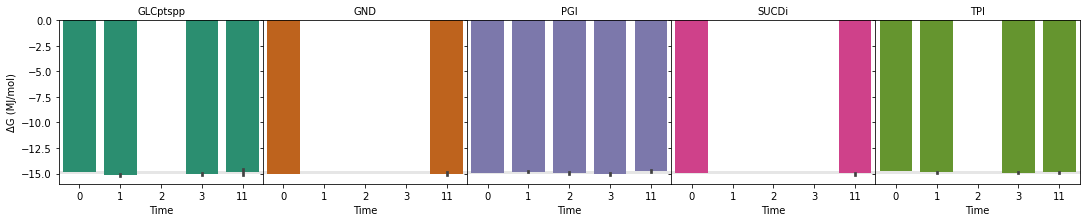

In [4]:
group = results[ dg_mask ].groupby([ 'strain', 'ko', 'time_point' ]).agg(np.sum).reset_index()
group['value'] *= 1e-3

def wt_line(data, **kwargs):
    ax = plt.gca()
    ax.fill_between( (-0.5, 4.5),
                    group[ group['ko'] == 'wt' ]['value'].min(),
                    group[ group['ko'] == 'wt' ]['value'].max(),
                    color = '.9', zorder = -1000 )

grid = sns.FacetGrid( group[ group['ko'] != 'wt' ], col = 'ko', hue = 'ko', palette = 'Dark2', despine = False, sharex = False )
grid.map( sns.barplot, 'time_point', 'value', order = [ 0, 1, 2, 3, 11 ] )
grid.map_dataframe( wt_line )

grid.fig.subplots_adjust( wspace = 0, hspace = 0 )

grid.set( xlim = (-0.5, 4.5) )
grid.set_titles('{col_name}')
grid.set_axis_labels('Time', 'ΔG (MJ/mol)')

grid.fig.savefig('results/Total.png', bbox_inches = 'tight')

plt.show()

## Pathway ΔG

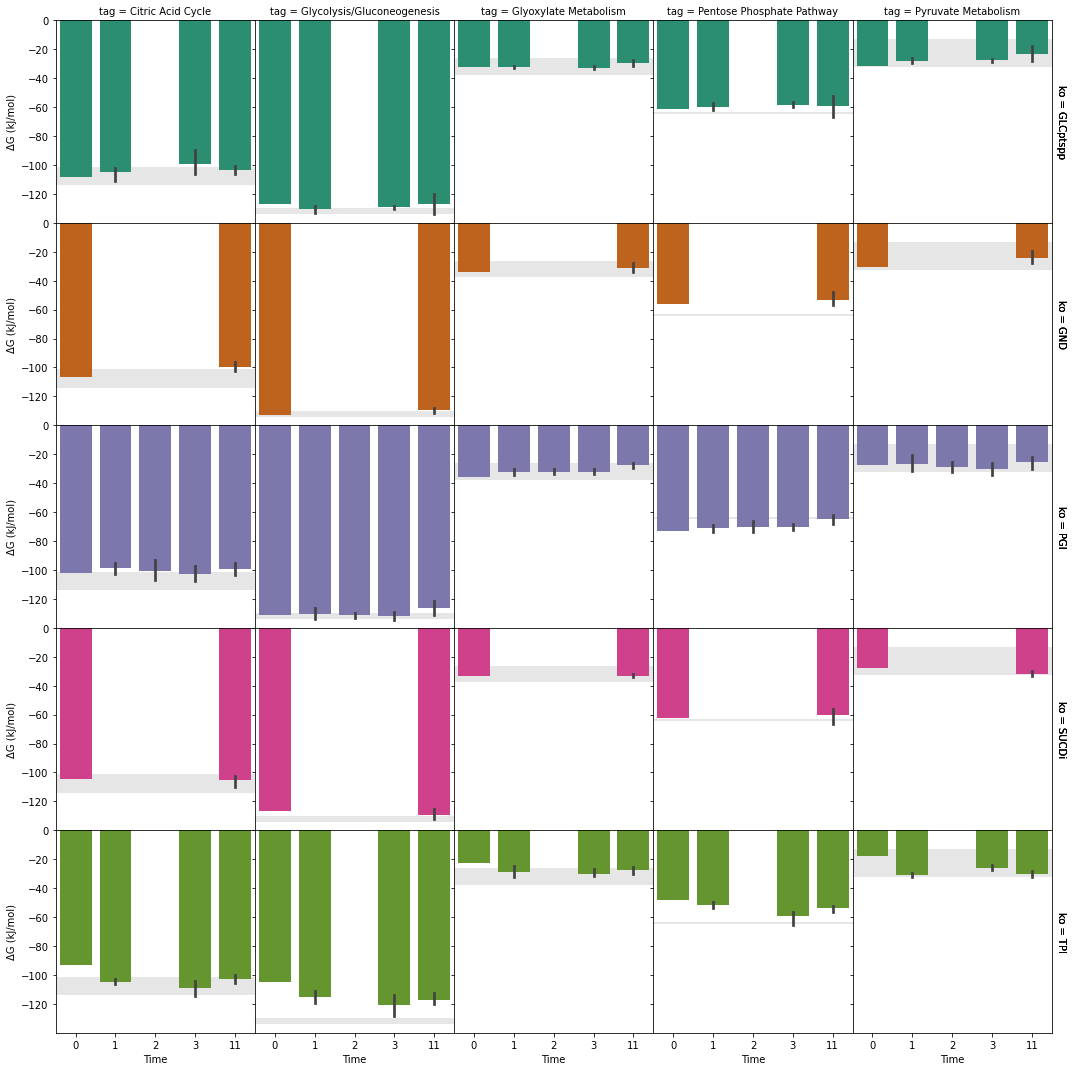

In [5]:
group = results[ dg_mask & ( ccm_mask ^ tag_mask['Oxidative Phosphorylation'] ) ].groupby([ 'strain', 'ko', 'time_point', 'tag' ]).agg(np.sum).reset_index()

def wt_line(data, **kwargs):
    wt_val = group[ (group['ko'] == 'wt') & ( group['tag'] == data['tag'].unique()[0] ) ]['value']
    ax = plt.gca()
    ax.fill_between( (-0.5, 4.5), wt_val.min(), wt_val.max(),
                    color = '.9', zorder = -1000 )

grid = sns.FacetGrid( group[ group['ko'] != 'wt' ], col = 'tag', row = 'ko', hue = 'ko', palette = 'Dark2', margin_titles = True, despine = False, sharex = False )
grid.map_dataframe( wt_line )
grid.map( sns.barplot, 'time_point', 'value', order = [ 0, 1, 2, 3, 11 ] )

grid.fig.subplots_adjust( wspace = 0, hspace = 0 )

grid.set_titles('{col_name}')
grid.set_axis_labels('Time', 'ΔG (kJ/mol)')
grid.set( ylim = (-140, 0), yticks = np.arange(-140, 1e-8, 20)[1:], )

grid.fig.savefig('results/Pathways.png', bbox_inches = 'tight')

plt.show()

## ΔG° Relaxation analysis

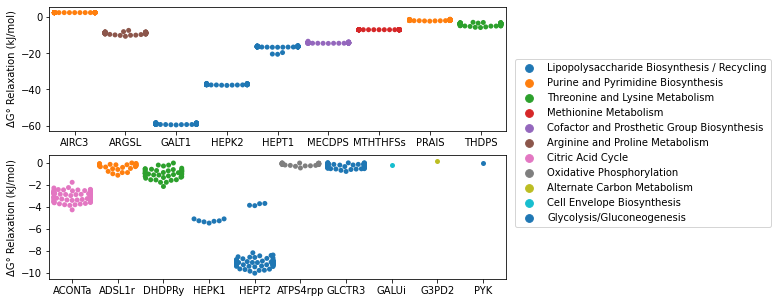

In [6]:
relax_reactions = results[ relax_mask ]['id'].value_counts().index.to_list()
hue_order = results[ relax_mask ]['tag'].value_counts().index.to_list()
half1 = relax_reactions[ : len(relax_reactions) // 2 ]

fig  = plt.figure( figsize = (12, 5) )
grid = plt.GridSpec( ncols = 2, nrows = 2, figure = fig, width_ratios = [3, 1] )
ax1 = fig.add_subplot( grid[0, 0] )
ax2 = fig.add_subplot( grid[1, 0] )
ax3 = fig.add_subplot( grid[:, 1] )
ax3.axis('off')

data = results[ relax_mask & results['id'].isin(half1) ]
sns.swarmplot( data = data, x = 'id', y = 'value', hue = 'tag', hue_order = hue_order, palette = 'tab10', ax = ax1 )

data = results[ relax_mask & ~results['id'].isin(half1) ]
sns.swarmplot( data = data, x = 'id', y = 'value', hue = 'tag', hue_order = hue_order, palette = 'tab10', ax = ax2 )

for ax in [ax1, ax2]:
    ax.get_legend().remove()
    ax.set_ylabel('ΔG° Relaxation (kJ/mol)')
    ax.set_xlabel('')

handles, labels = ax2.get_legend_handles_labels()
ax3.legend( handles, labels, loc = 'center' )

fig.savefig(f'results/Relaxation.png', bbox_inches = 'tight')

## Reaction dG

1. Filter reaction that have same dG as WT.

In [7]:
wt = results[ dg_mask & wt_mask ].groupby('id').agg( **{ 'lb': ( 'value', np.min ), 'ub': ( 'value', np.max ) } )

data = results[ dg_mask & ~wt_mask ]
group = data.groupby([ 'ko', 'time_point', 'id' ])

def diff_than_wt( data ):
    rxn_id = data['id'].iloc[0]
    lb, ub = data['value'].min(), data['value'].max()
    return ( ub < wt.at[rxn_id, 'lb'] ) | ( lb > wt.at[rxn_id, 'ub'] )

start = now()
filtered = group.filter( diff_than_wt )
print(f'Elapsed time: {(now()-start)/60:.2f} min')

filter_mask = np.zeros(results.shape[0], dtype=bool)
filter_mask[filtered.index] = True

Elapsed time: 0.21 min


2. Plotting

In [8]:
def wt_line(data, **kwargs):
    rxn_id = data['id'].unique()[0]
    ax = plt.gca()
    ax.fill_between( (-0.5, 4.5), wt.at[rxn_id, 'lb'], wt.at[rxn_id, 'ub'],
                    color = '.9', zorder = -1000 )

def plot_reaction( data, color, filename = None ):
    grid = sns.FacetGrid( data, col = 'id', despine = False )
    grid.map_dataframe( wt_line )
    grid.map( sns.barplot, 'time_point', 'value', order = [ 0, 1, 2, 3, 11 ], color = color )
    grid.map( plt.axhline, y = 0, c = '.5' )

    grid.fig.subplots_adjust( wspace = 0, hspace = 0 )

    grid.set_titles('{col_name}')
    grid.set_axis_labels('Time', 'ΔG (kJ/mol)')
    
    if filename:
        grid.fig.savefig(f'results/{filename}.png', bbox_inches = 'tight')
    
    plt.close(grid.fig)

palette = sns.color_palette('Dark2')
for pathway in CENTRAL_CARBON_METABOLISM:
    for i, ko_id in enumerate(['GLCptspp', 'GND', 'PGI', 'SUCDi', 'TPI']):
        # get number of reactions per condition
        data_mask = dg_mask & ko_mask[ko_id] & (results['id'] != ko_id) & tag_mask[pathway]
        thres = results[ data_mask ]['id'].value_counts()[0]
        # get number of filtered reactions per condition
        data = results[ data_mask & filter_mask ]
        id_count = data['id'].value_counts()
        # only show reactions that differ from WT in all conditions (time/KO)
        id_mask = results['id'].isin( id_count[ id_count >= thres ].index ) 
        # plot
        if id_mask.any():
            filename = ko_id + '_' + pathway.replace('/', '-')
            plot_reaction( results[ data_mask & id_mask ], palette[i], filename )